Fake news detection model using [LSTM(Long short term memory network)](https://en.wikipedia.org/wiki/Long_short-term_memory)

Libraries configuration

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 
import re
from wordcloud import WordCloud

Importing all the functions

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

Exploring data

Fake data set

In [9]:
fake=pd.read_csv('/Fake.csv')

Preprocessing data

In [11]:
fake=fake.dropna(axis=0)
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

Visualizing fake data set

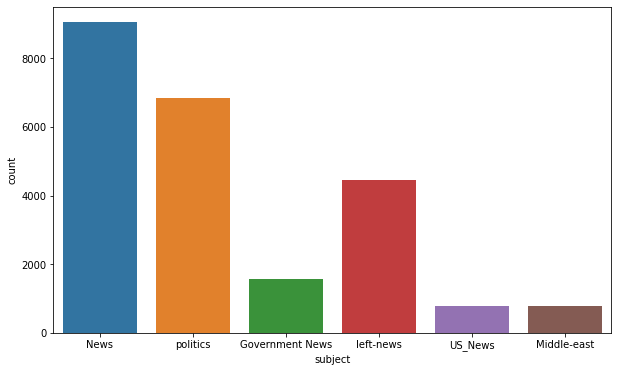

In [17]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject',data=fake)

Visualizing text using Wordcloud

In [23]:
text=' '.join(fake['text'].tolist())


Word which are coming frequently in the fake news can be seen in the image below

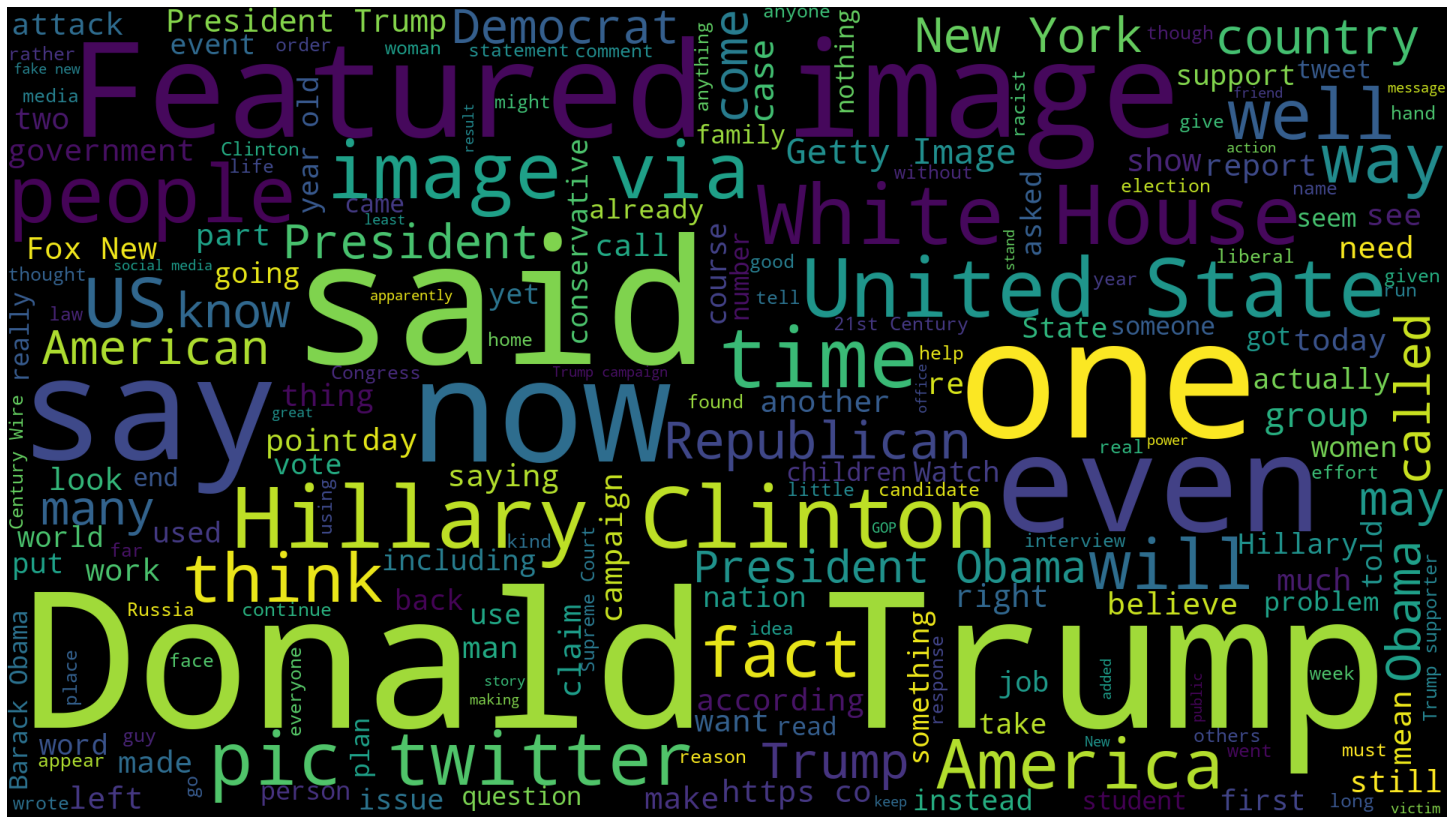

In [26]:
wordcloud=WordCloud(width=1920,height=1080).generate(text)
fig=plt.figure(figsize=(20,20))
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud)

Real news data set

In [27]:
real=pd.read_csv('/True.csv')

Preprocessing data

In [30]:
real=real.dropna(axis=0)
real.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

Visualizing the subject of news

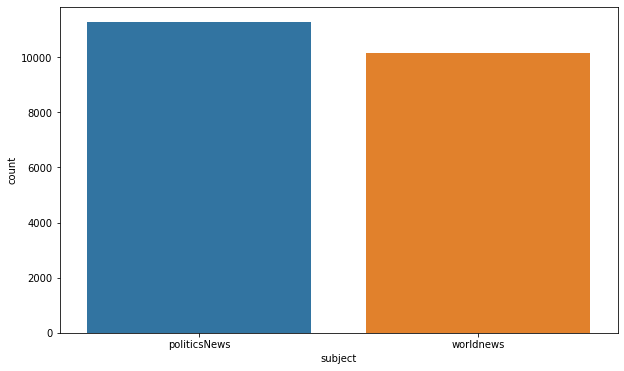

In [32]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject',data=real)

In [33]:
realtext=' '.join(real['text'].tolist())

Visulaizing real data using wordcloud

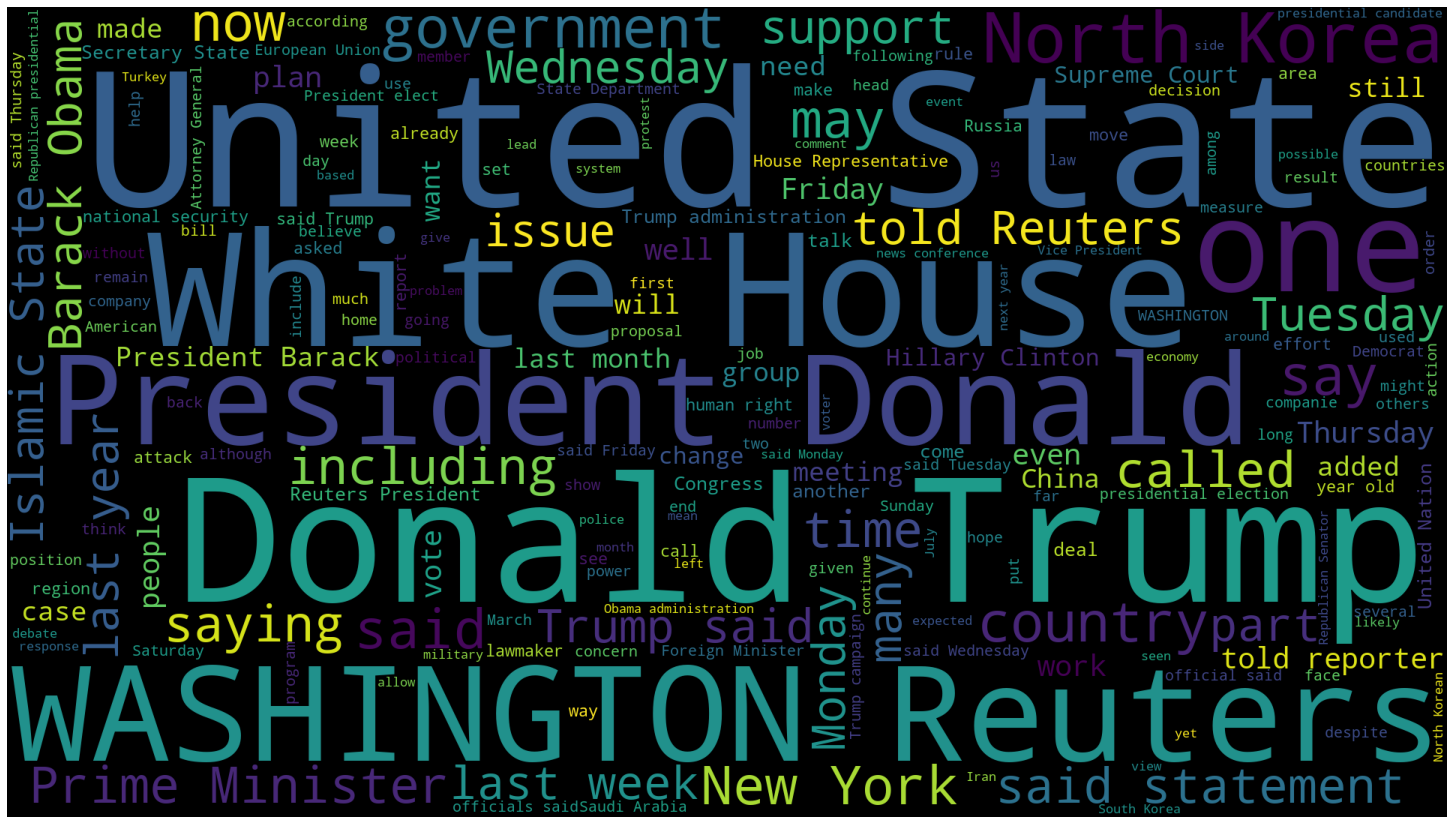

In [34]:
wordcloud=WordCloud(width=1920,height=1080).generate(realtext)
fig=plt.figure(figsize=(20,20))
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud)

```In both above pictures we can see nouns that are quite frequent so what is the difference basically?
In the image of real data we can see that it contains reference (Washington (Reuters)) to the news where as if it was a fake news it won't have any reference```

In [35]:
fake.sample(5)

,title,text,subject,date
15471,THIS BIG ANNOUNCEMENT IS YET ANOTHER REASON NO...,Another turn left for the Hillster so no schoo...,politics,"Jul 12, 2015"
8631,Millionaire Palin And Billioniare Trump Beg G...,If you ve ever noticed how Donald Trump brags ...,News,"January 20, 2016"
9351,PELOSI CLAIMS Congressman Who Shows Up for Mee...,Michigan Congressman John Conyers has been in ...,politics,"Nov 26, 2017"
20513,GREAT NEWS! Thanks To New York’s Socialist May...,The social rot continues in a city that was mi...,left-news,"May 27, 2016"
16496,BRUTALLY HONEST BILLBOARD Turns Heads In State...,American citizens should be more concerned abo...,Government News,"Jul 16, 2016"


In [36]:
real.sample(5)

,title,text,subject,date
19060,Mexico City gets unsteadily back on its feet a...,MEXICO CITY (Reuters) - Mexico City s infamous...,worldnews,"September 25, 2017"
1936,Trump to nominate Juster to be ambassador to I...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"September 2, 2017"
13619,North Korea to make announcement at 0330 GMT: ...,SEOUL (Reuters) - North Korea will make an ann...,worldnews,"November 29, 2017"
1255,Trump says he can end Iran deal if no action t...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"October 13, 2017"
8454,FBI to give Congress report on lack of charges...,WASHINGTON (Reuters) - The FBI on Tuesday will...,politicsNews,"August 16, 2016"


Cleaning the data

1. Selecting the unknown publishers from the real data
2. Removing the tweets because they have same reuter and the max length of 259 characters.

In [43]:
un_publishers=[]

for indx,row in enumerate(real.text.values):
  try:
    record=row.split('-',maxsplit=1)
    record[1]
    assert(len(record[0])<120) #point 2
  except:
    un_publishers.append(indx)

In [44]:
len(un_publishers)

222

So we need to remove 31 rows containg no reuter or a tweet from twitter

In [47]:
real.iloc[un_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [50]:
publisher=[]
tmp_text=[]

for indx,row in enumerate(real.text.values):
  if indx in un_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')
  else:
    record=row.split('-',maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [52]:
real['publisher']=publisher
real['text']=tmp_text

In [79]:
real.shape

(21416, 5)

In [77]:
empty_fake_index=[index for index,text in enumerate(fake.text.tolist()) if str(text).strip()==""]

In [81]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [82]:
fake.shape

(23481, 4)

In [85]:
rows=fake.index[empty_fake_index]

In [87]:
fake.drop(rows,inplace=True)

In [88]:
fake.shape

(22851, 4)

In [90]:
real['text']=real['title']+" "+real['text']
fake['text']=fake['title']+" "+fake['text']

real['text']=real['text'].apply(lambda x:str(x).lower())
fake['text']=fake['text'].apply(lambda x:str(x).lower())

Preprocessing text

In [91]:
real['class']=1
fake['class']=0

In [93]:
real.columns
fake.columns

Index(['title', 'text', 'subject', 'date', 'class'], dtype='object')

In [94]:
real=real[['text','class']]
fake=fake[['text','class']]

In [96]:
data=real.append(fake,ignore_index=True)
data

,text,class
0,"as u.s. budget fight looms, republicans flip t...",1
1,u.s. military to accept transgender recruits o...,1
2,senior u.s. republican senator: 'let mr. muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1
...,...,...
44262,mcpain: john mccain furious that iran treated ...,0
44263,justice? yahoo settles e-mail privacy class-ac...,0
44264,sunnistan: us and allied ‘safe zone’ plan to t...,0
44265,how to blow $700 million: al jazeera america f...,0


Installing text preprocessor

In [98]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4
!pip install textblob
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

     |████████████████████████████████| 12.0 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-ygeqldaz
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-ygeqldaz
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=11754 sha256=711971a4296429a9f9d7b19144767e217111b434a6670698583080e13297d7b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-v0ivreof/wheels/0d/b3/29/bfe3deffda68980088d17b81331be6667e837ffb4a071bae82
Successfully built preprocess-kgptalkie


In [99]:
import preprocess_kgptalkie as ps

In [100]:
data['text']=data['text'].apply(lambda x:ps.remove_special_chars(x))

Word to vector conversion of the text data

In [123]:
import gensim

In [124]:
y=data['class'].values

In [135]:
X=[d.split() for d in data['text'].tolist()]

In [136]:
DIM=100
w2v_model=gensim.models.Word2Vec(sentences=X,size=DIM,window=5,min_count=1)

In [137]:
w2v_model.wv.most_similar('india')

[('pakistan', 0.76421719789505),
 ('malaysia', 0.7391948699951172),
 ('thailand', 0.7192661166191101),
 ('china', 0.7027378678321838),
 ('australia', 0.6727938652038574),
 ('norway', 0.6696648597717285),
 ('algeria', 0.6605863571166992),
 ('japan', 0.6587715148925781),
 ('canada', 0.6514642238616943),
 ('beijing', 0.6458016633987427)]

In [138]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X)

In [139]:
X=tokenizer.texts_to_sequences(X)

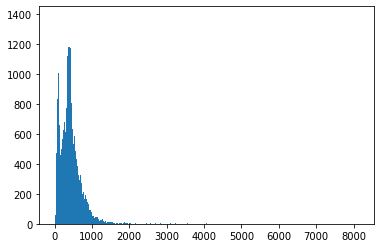

In [140]:
plt.hist([len(x) for x in X],bins=700)
plt.show()

In [141]:
nos=np.array([len(x) for x in X])
len(nos[nos>1000])

1662

In [142]:
maxlen=1000
X=pad_sequences(X,maxlen=maxlen)

In [145]:
vocab_size=len(tokenizer.word_index)+1
vocab=tokenizer.word_index

In [150]:
def get_wight_matrix(model):
  weight_matrix=np.zeros((vocab_size,DIM))
  for word, i in vocab.items():
    weight_matrix[i]=model.wv[word]
  return weight_matrix

In [151]:
embedding_vectors=get_wight_matrix(w2v_model)

In [152]:
embedding_vectors.shape

(231798, 100)

In [155]:
model=Sequential()
model.add(Embedding(vocab_size,output_dim=DIM,weights=[embedding_vectors],input_length=maxlen,trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [156]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         23179800  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 23,297,177
Trainable params: 117,377
Non-trainable params: 23,179,800
_________________________________________________________________


In [157]:
X_train,X_test,y_train,y_tets=train_test_split(X,y)

In [158]:
model.fit(X_train,y_train,validation_split=0.3,epochs=6)

Epoch 1/6
727/727 [==============================] - 124s 161ms/step - loss: 0.1387 - acc: 0.9482 - val_loss: 0.0766 - val_acc: 0.9747
Epoch 2/6
727/727 [==============================] - 116s 160ms/step - loss: 0.0460 - acc: 0.9854 - val_loss: 0.0747 - val_acc: 0.9753
Epoch 3/6
727/727 [==============================] - 117s 160ms/step - loss: 0.0340 - acc: 0.9882 - val_loss: 0.0333 - val_acc: 0.9895
Epoch 4/6
727/727 [==============================] - 116s 160ms/step - loss: 0.0219 - acc: 0.9927 - val_loss: 0.0388 - val_acc: 0.9873
Epoch 5/6
727/727 [==============================] - 116s 160ms/step - loss: 0.0117 - acc: 0.9961 - val_loss: 0.0250 - val_acc: 0.9922
Epoch 6/6
727/727 [==============================] - 116s 160ms/step - loss: 0.0063 - acc: 0.9981 - val_loss: 0.0197 - val_acc: 0.9934


In [159]:
y_pred=(model.predict(X_test)>0.5).astype(int)

In [161]:
accuracy_score(y_tets,y_pred)

0.9927713020692148

In [163]:
print(classification_report(y_tets,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5672
           1       0.99      0.99      0.99      5395

    accuracy                           0.99     11067
   macro avg       0.99      0.99      0.99     11067
weighted avg       0.99      0.99      0.99     11067



Exporting the ml model and vectorizer

In [164]:
import joblib

In [167]:
joblib.dump(tokenizer,'/tokenizer.joblib')
model.save('/fake_news_model.h5')

Testing the model

In [172]:
x=["Breaking news terrorist invaded pakistan"]
x=tokenizer.texts_to_sequences(x)
x=pad_sequences(x,maxlen=maxlen)

In [173]:
model.predict(x)

array([[0.00062079]], dtype=float32)